# Hyperparameter Optimization with HPO Module

This notebook uses the refactored `hpo.py` module for parallel hyperparameter optimization.

## Setup and Imports

In [1]:
import sys
sys.path.insert(0, '../code')

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from dtscan import psr
from cluster_sets import clusters_paper, load_s5
from hpo import run_parallel_optimization, results_to_dataframe

print("✓ All imports loaded")

✓ All imports loaded


## Configuration

In [2]:
HYPERPARAMETER_RANGES = {
    'DTSCAN': {
        'MinPts': {'type': 'int', 'range': (2, 25)},
        'area_threshold': {'type': 'float', 'range': (-50.0, 0)},
        'length_threshold': {'type': 'float', 'range': (-50.0, 0)}
    },
    'DBSCAN': {
        'eps': {'type': 'float', 'range': (0.1, 2.0)},
        'min_samples': {'type': 'int', 'range': (3, 12)}
    },
    'KMeans': {
        'n_clusters': {'type': 'int', 'range': (2, 12)},
        'n_init': {'type': 'categorical', 'options': [5, 10, 20, 50]}
    },
    'Spectral': {
        'n_clusters': {'type': 'int', 'range': (2, 12)},
        'n_neighbors': {'type': 'int', 'range': (5, 30)}
    },
    'GMM': {
        'n_components': {'type': 'int', 'range': (2, 12)},
        'covariance_type': {'type': 'categorical', 'options': ['full', 'tied', 'diag', 'spherical']},
        'n_init': {'type': 'categorical', 'options': [1, 5, 10, 20]}
    },
    'ASCDT': {
        'min_cluster_size': {'type': 'int', 'range': (2, 20)},
        'beta': {'type': 'float', 'range': (1.0, 1.5)}
    },
    'DTC': {
        'min_pts': {'type': 'int', 'range': (2, 20)},
        'local_std': {'type': 'float', 'range': (1.0, 5.0)}
    },
    'DTCSVM': {
        'min_pts': {'type': 'int', 'range': (2, 20)},
        'local_std': {'type': 'float', 'range': (1.0, 5.0)},
        'svm_c': {'type': 'float', 'range': (0.1, 10.0)},
        'svm_gamma': {'type': 'categorical', 'options': ['scale', 'auto']}
    }
}

# Configuration
N_TRIALS = 50
EXPERIMENT_NAME = "HPO_v2_Benchmark_Clusters2"
ALGORITHMS = ['DTSCAN', 'DBSCAN', 'KMeans', 'Spectral', 'GMM', 'ASCDT', 'DTC', 'DTCSVM']
N_JOBS = -1  # Use all CPU cores

print("✓ Configuration loaded")
print(f"  Algorithms: {len(ALGORITHMS)}")
print(f"  Trials per task: {N_TRIALS}")

✓ Configuration loaded
  Algorithms: 8
  Trials per task: 50


## Load Datasets

In [3]:
# Load datasets
S1, S2, S3, S4 = clusters_paper()
S5 = load_s5()

datasets = {
    'S1': (S1[['x', 'y']].values, S1['label'].values),
    'S2': (S2[['x', 'y']].values, S2['label'].values),
    'S3': (S3[['x', 'y']].values, S3['label'].values),
    'S4': (S4[['x', 'y']].values, S4['label'].values),
    'S5': (S5[['x', 'y']].values, S5['label'].values)
}

print("✓ Datasets loaded")
for name, (X, labels) in datasets.items():
    n_clusters = len(np.unique(labels[labels != -1]))
    print(f"  {name}: {X.shape[0]} points, {n_clusters} clusters")

✓ Datasets loaded
  S1: 788 points, 7 clusters
  S2: 300 points, 3 clusters
  S3: 373 points, 2 clusters
  S4: 399 points, 6 clusters
  S5: 1860 points, 18 clusters


## Run Parallel Optimization

This uses the `run_parallel_optimization` function from `hpo.py` which handles:
- Parallel execution across datasets and algorithms
- MLflow logging
- Progress tracking
- Error handling

In [4]:
# Run optimization
results = run_parallel_optimization(
    datasets=datasets,
    algorithms=ALGORITHMS,
    metric_func=psr,
    hyperparameter_ranges=HYPERPARAMETER_RANGES,
    n_trials=N_TRIALS,
    experiment_name=EXPERIMENT_NAME,
    n_jobs=N_JOBS,
    mlflow_uri="file:../mlruns",
    verbose=True
)


STARTING PARALLEL OPTIMIZATION
Datasets: ['S1', 'S2', 'S3', 'S4', 'S5']
Algorithms: ['DTSCAN', 'DBSCAN', 'KMeans', 'Spectral', 'GMM', 'ASCDT', 'DTC', 'DTCSVM']
Trials per task: 50
Parallelization: Pool (across dataset-algorithm combinations)
Parallel processes: 8
Total tasks: 40

[2025-11-25 19:20:42] Dataset: S1, Algorithm: DBSCAN, Trial: 1/50[2025-11-25 19:20:42] Dataset: S1, Algorithm: DTSCAN, Trial: 1/50[2025-11-25 19:20:42] Dataset: S1, Algorithm: Spectral, Trial: 1/50[2025-11-25 19:20:42] Dataset: S1, Algorithm: KMeans, Trial: 1/50[2025-11-25 19:20:42] Dataset: S1, Algorithm: DTCSVM, Trial: 1/50[2025-11-25 19:20:42] Dataset: S1, Algorithm: GMM, Trial: 1/50[2025-11-25 19:20:42] Dataset: S1, Algorithm: DTC, Trial: 1/50[2025-11-25 19:20:42] Dataset: S1, Algorithm: ASCDT, Trial: 1/50







[2025-11-25 19:20:42] Dataset: S1, Algorithm: DBSCAN, Trial: 2/50
[2025-11-25 19:20:42] Dataset: S1, Algorithm: DBSCAN, Trial: 3/50
[2025-11-25 19:20:42] Dataset: S1, Algorithm: DBSCAN, Trial: 4/

## Results Summary

In [14]:
# Visualization Grid: Show clustering results for all datasets and algorithms
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, HDBSCAN
from sklearn.mixture import GaussianMixture
from dtscan import DTSCAN
from dtc import DTC
from dtcsvm import DTCSVM
from ascdt import ASCDT
import io
from contextlib import redirect_stdout

def generate_distinct_colors(n_colors):
    """Generate n distinct colors for visualization."""
    colors = []
    colormaps = [plt.cm.tab20, plt.cm.Set3, plt.cm.Pastel1, plt.cm.Pastel2, 
                 plt.cm.Dark2, plt.cm.Accent, plt.cm.Paired]
    
    for cmap in colormaps:
        n_cmap_colors = cmap.N if hasattr(cmap, 'N') else 256
        for i in range(n_cmap_colors):
            if len(colors) >= n_colors:
                break
            colors.append(mcolors.to_hex(cmap(i / max(n_cmap_colors - 1, 1))))
        if len(colors) >= n_colors:
            break
    
    # Generate more colors using HSV if needed
    if len(colors) < n_colors:
        remaining = n_colors - len(colors)
        for i in range(remaining):
            hue = (i * 0.618033988749895) % 1.0
            saturation = 0.7 + (i % 3) * 0.1
            value = 0.8 + (i % 2) * 0.15
            rgb = mcolors.hsv_to_rgb([hue, saturation, value])
            colors.append(mcolors.to_hex(rgb))
    
    return colors[:n_colors]

def cluster_data(X, X_scaled, algorithm, params):
    """Run clustering with given parameters."""
    # Make a copy to avoid modifying original
    params_copy = params.copy()
    use_scaled = params_copy.pop('use_scaled', None)
    
    # Determine which data to use
    if algorithm == 'DBSCAN':
        X_use = X_scaled  # DBSCAN always uses scaled data
    elif algorithm in ['DTC', 'DTCSVM']:
        X_use = X  # Triangulation algorithms always use unscaled data
    else:
        X_use = X_scaled if use_scaled else X
    
    try:
        if algorithm == 'DTSCAN':
            model = DTSCAN(**params_copy)
            f = io.StringIO()
            with redirect_stdout(f):
                labels = model.fit_predict(X_use)
        elif algorithm == 'DBSCAN':
            model = DBSCAN(**params_copy)
            labels = model.fit_predict(X_use)
        elif algorithm == 'KMeans':
            model = KMeans(**params_copy, random_state=42)
            labels = model.fit_predict(X_use)
        elif algorithm == 'Spectral':
            model = SpectralClustering(**params_copy, random_state=42)
            labels = model.fit_predict(X_use)
        elif algorithm == 'GMM':
            # GMM uses n_components instead of n_clusters
            if 'n_clusters' in params_copy:
                params_copy['n_components'] = params_copy.pop('n_clusters')
            model = GaussianMixture(**params_copy, random_state=42)
            labels = model.fit_predict(X_use)
        elif algorithm == 'HDBSCAN':
            model = HDBSCAN(**params_copy)
            labels = model.fit_predict(X_use)
        elif algorithm == 'ASCDT':
            model = ASCDT(**params_copy)
            f = io.StringIO()
            with redirect_stdout(f):
                labels = model.fit_predict(X_use)
        elif algorithm == 'DTC':
            # Handle parameter name variations (convert min_pts to minPts)
            dtc_params = params_copy.copy()
            if 'min_pts' in dtc_params:
                dtc_params['minPts'] = dtc_params.pop('min_pts')
            # minPts should already be correct if present
            
            df = pd.DataFrame(X_use, columns=['x', 'y'])
            model = DTC(data=df, **dtc_params)
            f = io.StringIO()
            with redirect_stdout(f):
                result_df = model.tri_dbscan()
            if result_df is None or 'est_clust' not in result_df.columns:
                return np.array([-1] * len(X_use))
            result_df = result_df.sort_values('index').reset_index(drop=True)
            labels = result_df['est_clust'].values
            labels = np.where(labels == 0, -1, labels)
        elif algorithm == 'DTCSVM':
            # Handle parameter name variations (convert min_pts to minPts)
            dtcsvm_params = params_copy.copy()
            if 'min_pts' in dtcsvm_params:
                dtcsvm_params['minPts'] = dtcsvm_params.pop('min_pts')
            # minPts should already be correct if present
            
            df = pd.DataFrame(X_use, columns=['x', 'y'])
            model = DTCSVM(data=df, **dtcsvm_params)
            f = io.StringIO()
            with redirect_stdout(f):
                result_df = model.tri_dbscan()
            if result_df is None or 'est_clust' not in result_df.columns:
                return np.array([-1] * len(X_use))
            result_df = result_df.sort_values('index').reset_index(drop=True)
            labels = result_df['est_clust'].values
            labels = np.where(labels == 0, -1, labels)
        else:
            return None
        
        return labels
    except Exception as e:
        print(f"Error clustering {algorithm}: {e}")
        import traceback
        traceback.print_exc()
        return None

def plot_clusters(X, labels, ax, title):
    """Plot clusters on given axes."""
    unique_labels = np.unique(labels)
    cluster_labels = unique_labels[unique_labels >= 0]  # Only cluster labels (exclude noise)
    n_clusters = len(cluster_labels)
    
    # Create color map: noise is black, clusters get distinct colors
    color_map = {}
    if n_clusters > 0:
        colors_list = generate_distinct_colors(n_clusters)
        # Map cluster labels to colors
        for i, label in enumerate(cluster_labels):
            color_map[label] = colors_list[i]
    
    # Noise always gets black
    if -1 in unique_labels:
        color_map[-1] = '#000000'
    
    # Plot each label
    for label in unique_labels:
        mask = labels == label
        color = color_map.get(label, '#808080')
        ax.scatter(X[mask, 0], X[mask, 1], c=color, s=20, alpha=0.6, 
                  edgecolors='k', linewidths=0.3, label=f'Cluster {label}' if label >= 0 else 'Noise')
    
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel('X', fontsize=8)
    ax.set_ylabel('Y', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

print("✓ Visualization functions defined")


✓ Visualization functions defined


Generating visualization grids...


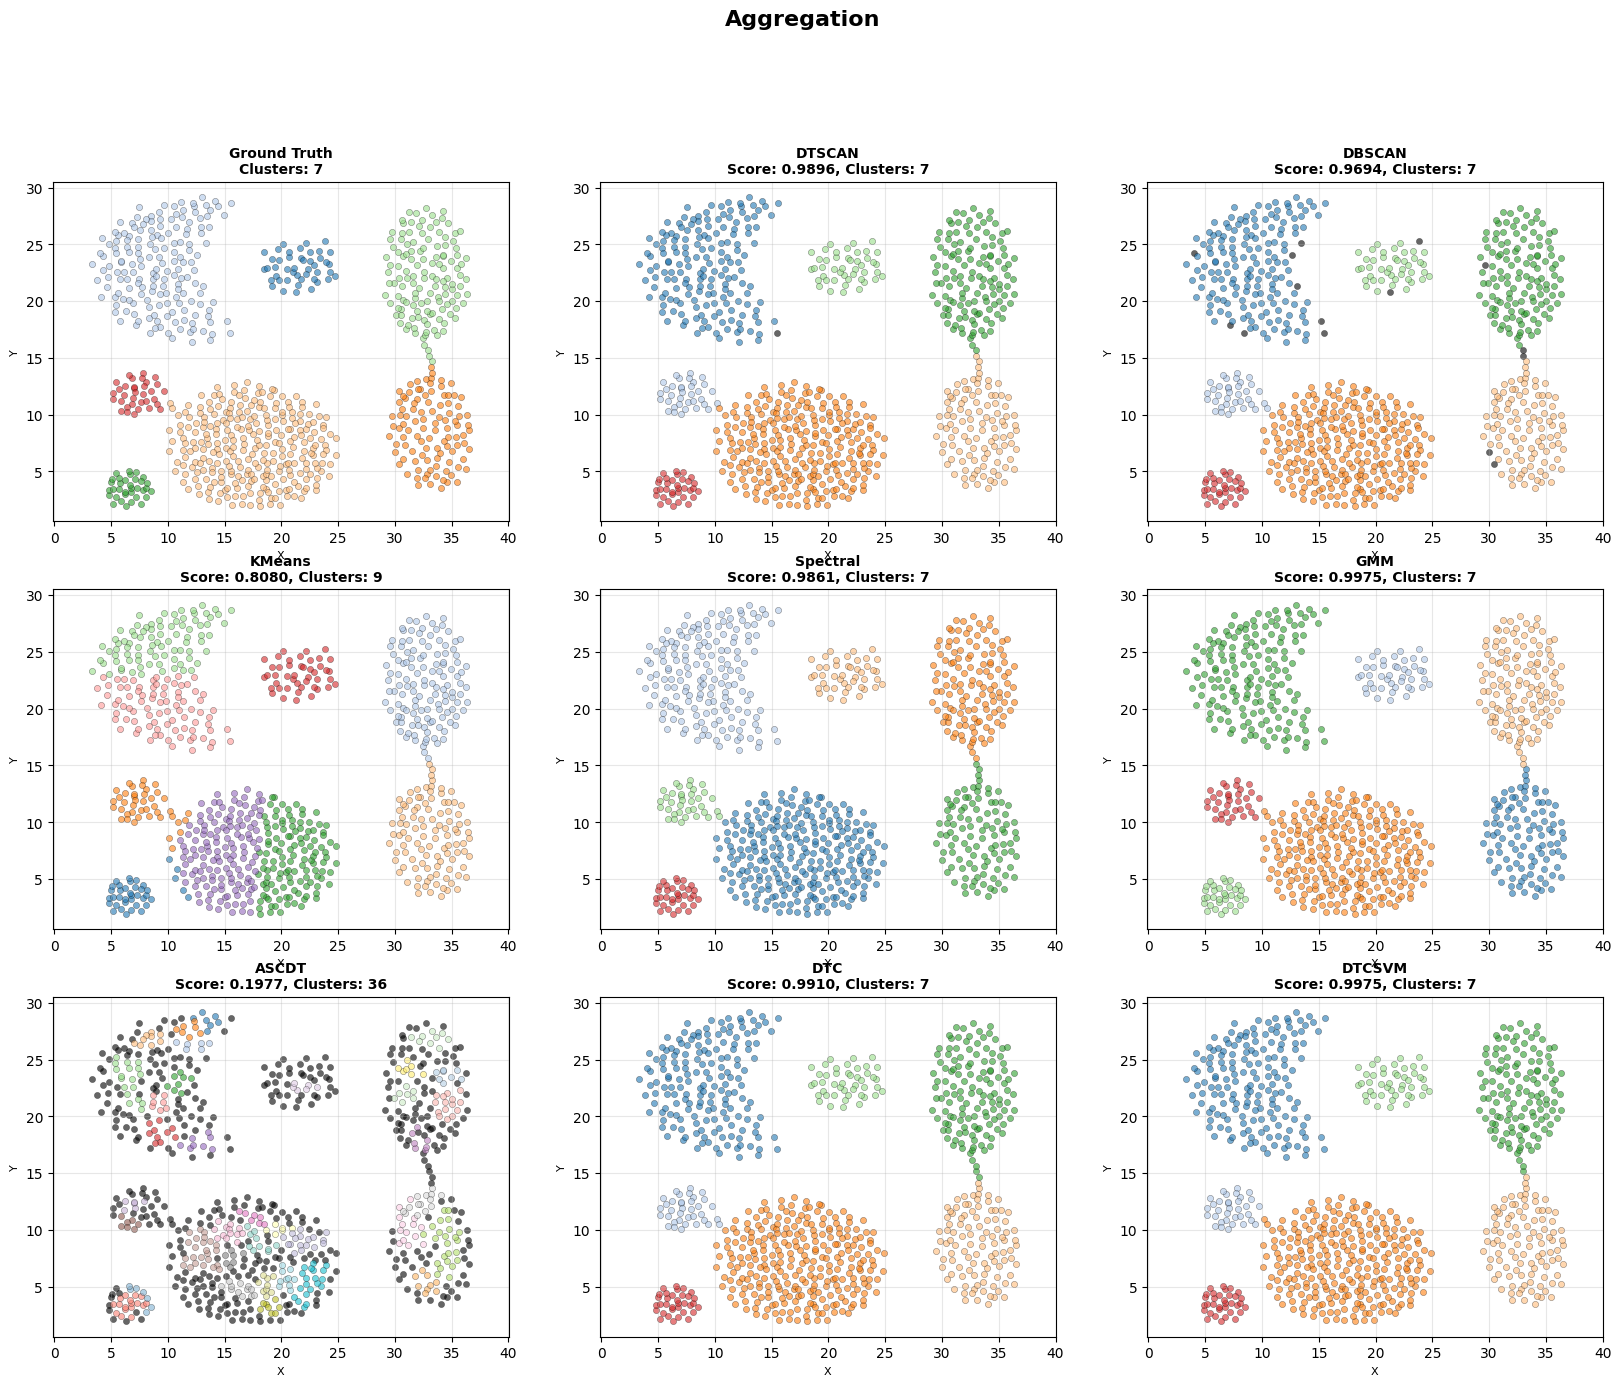

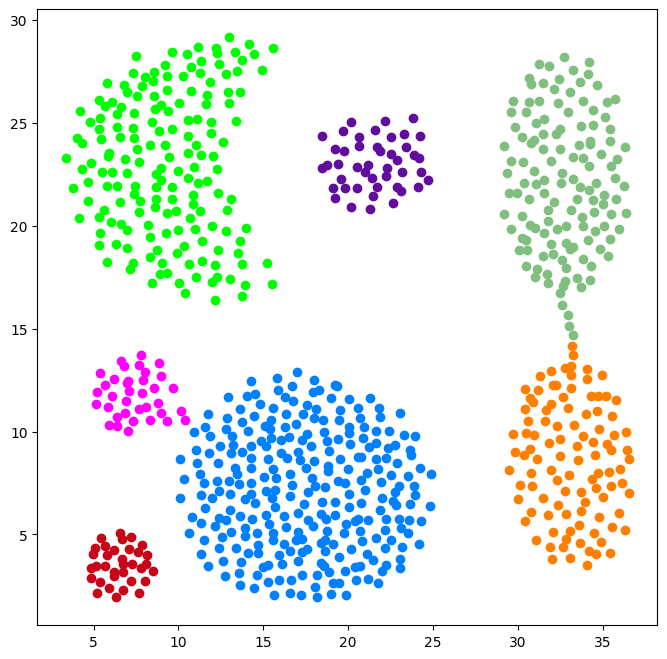

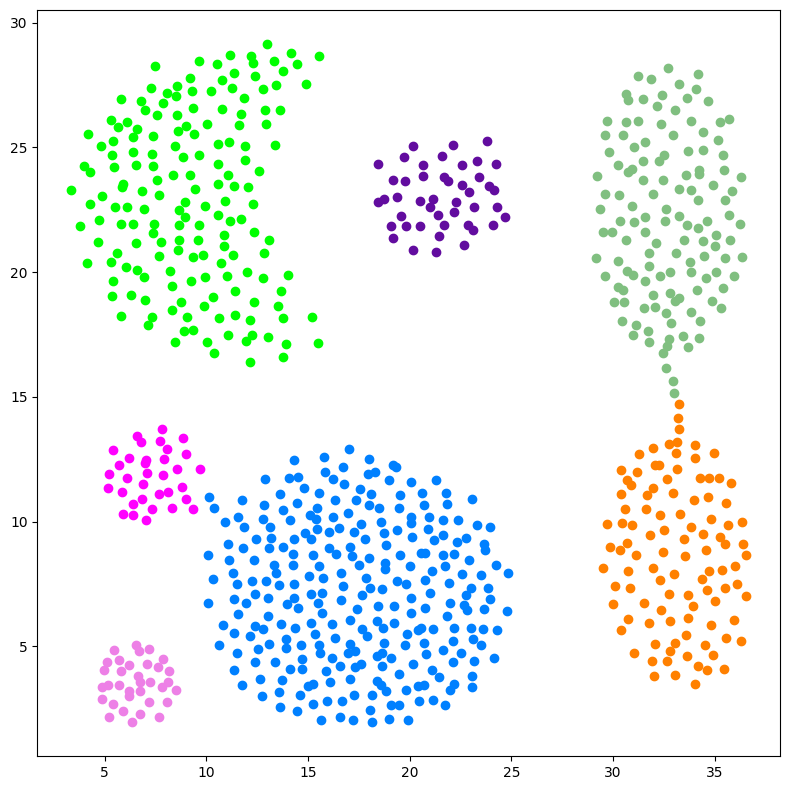

✓ S1 visualization complete


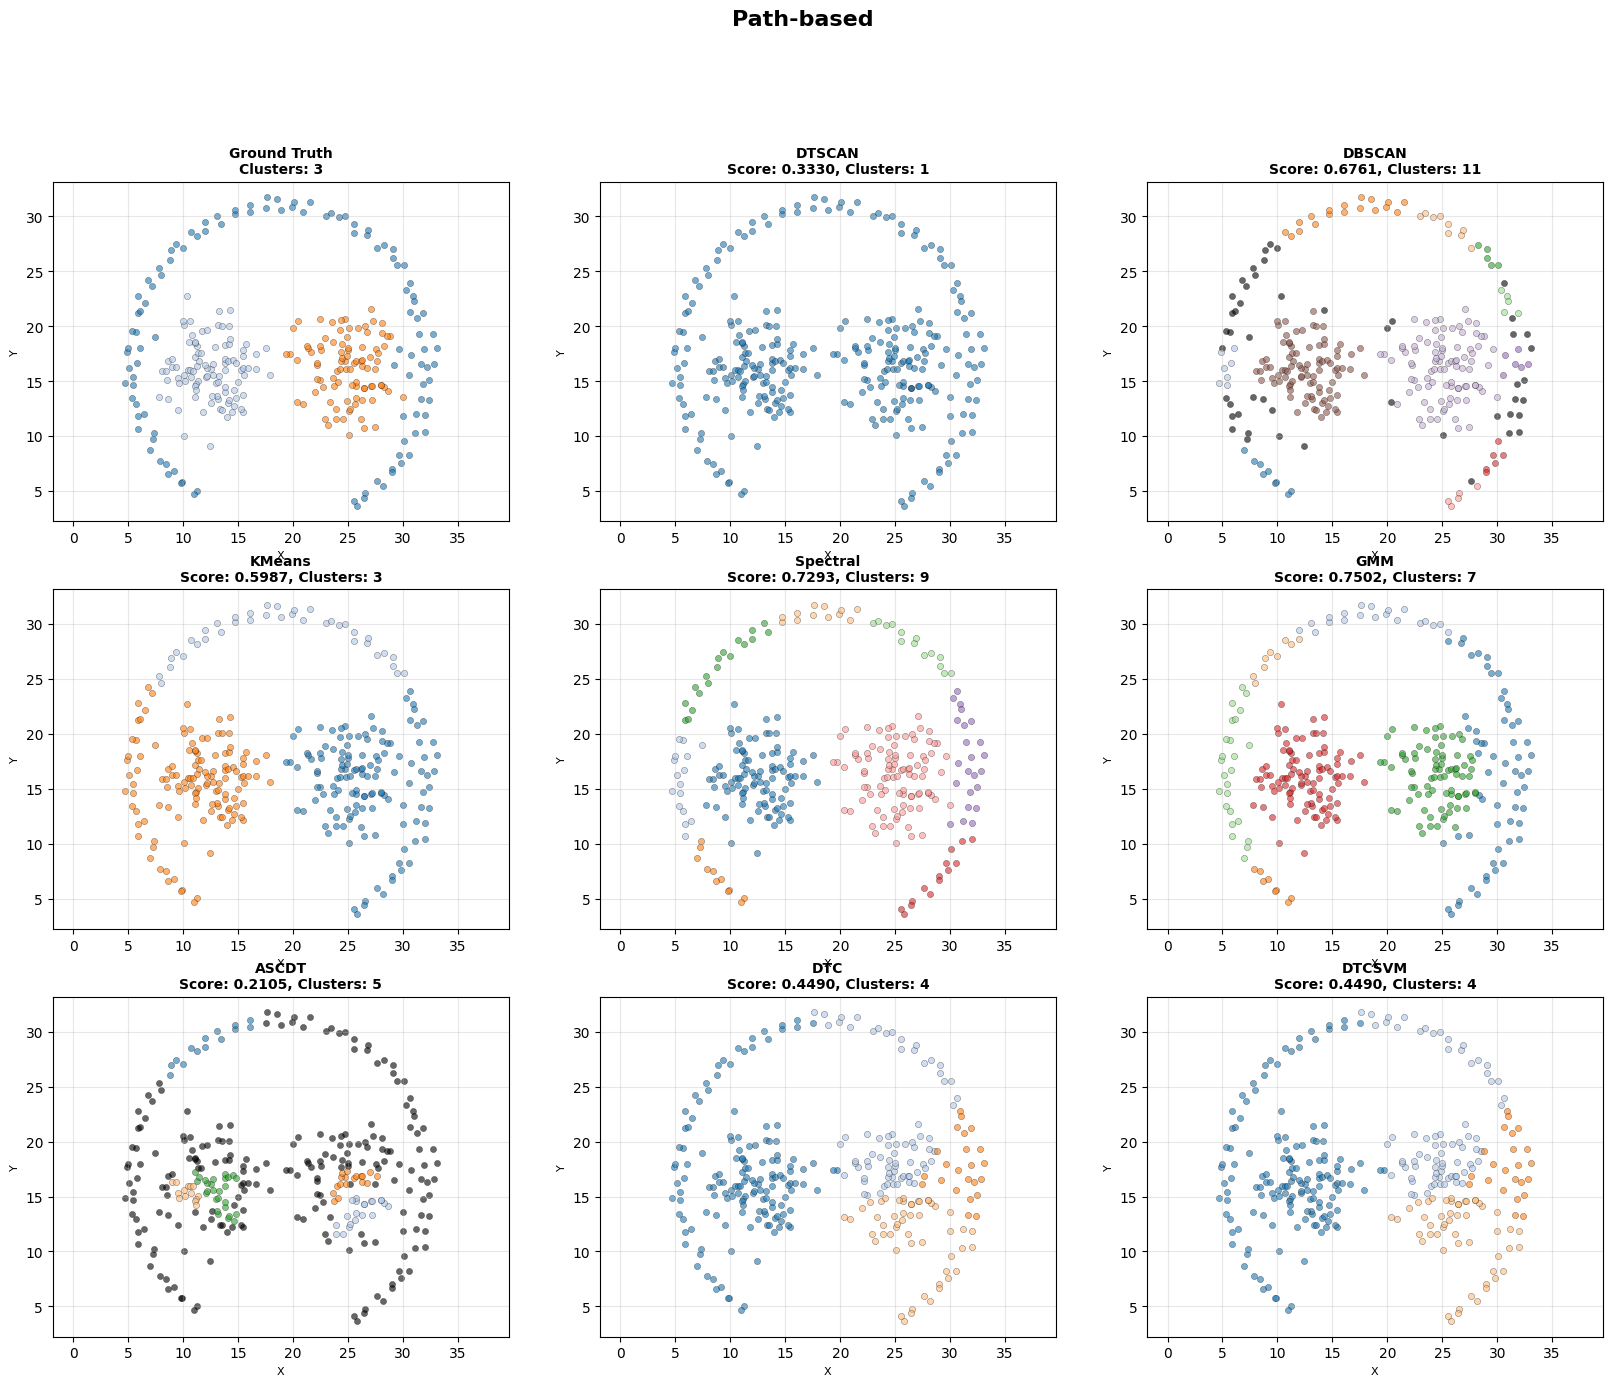

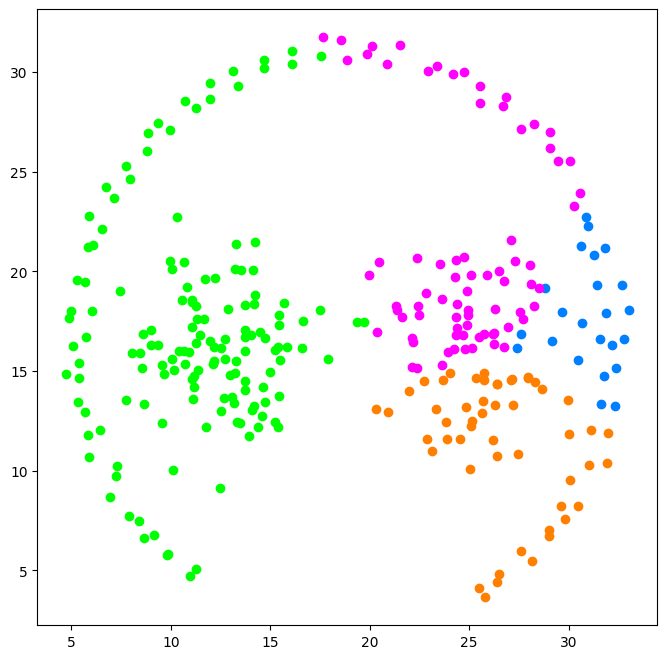

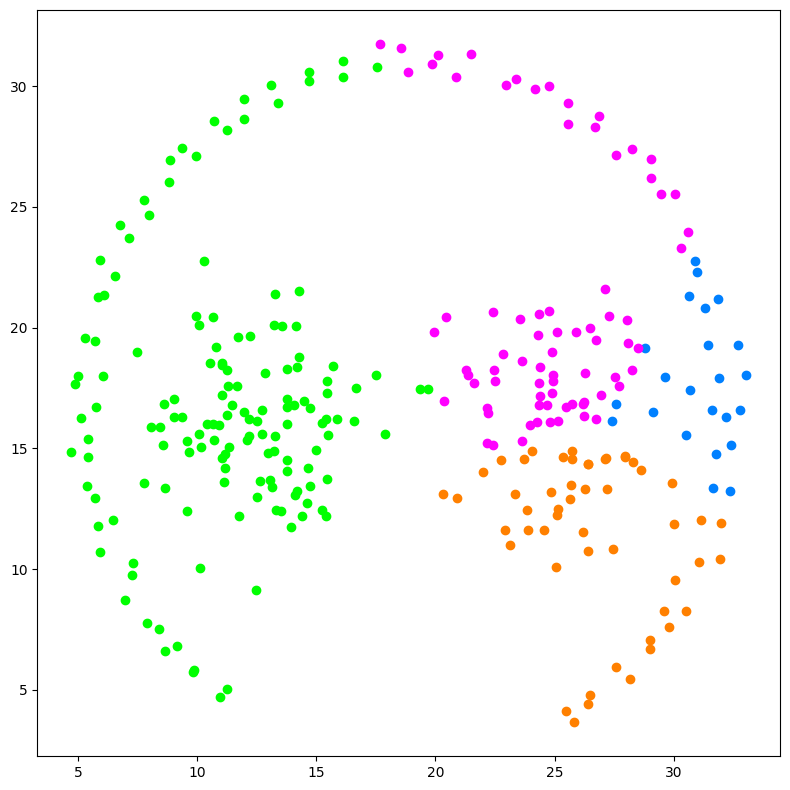

✓ S2 visualization complete


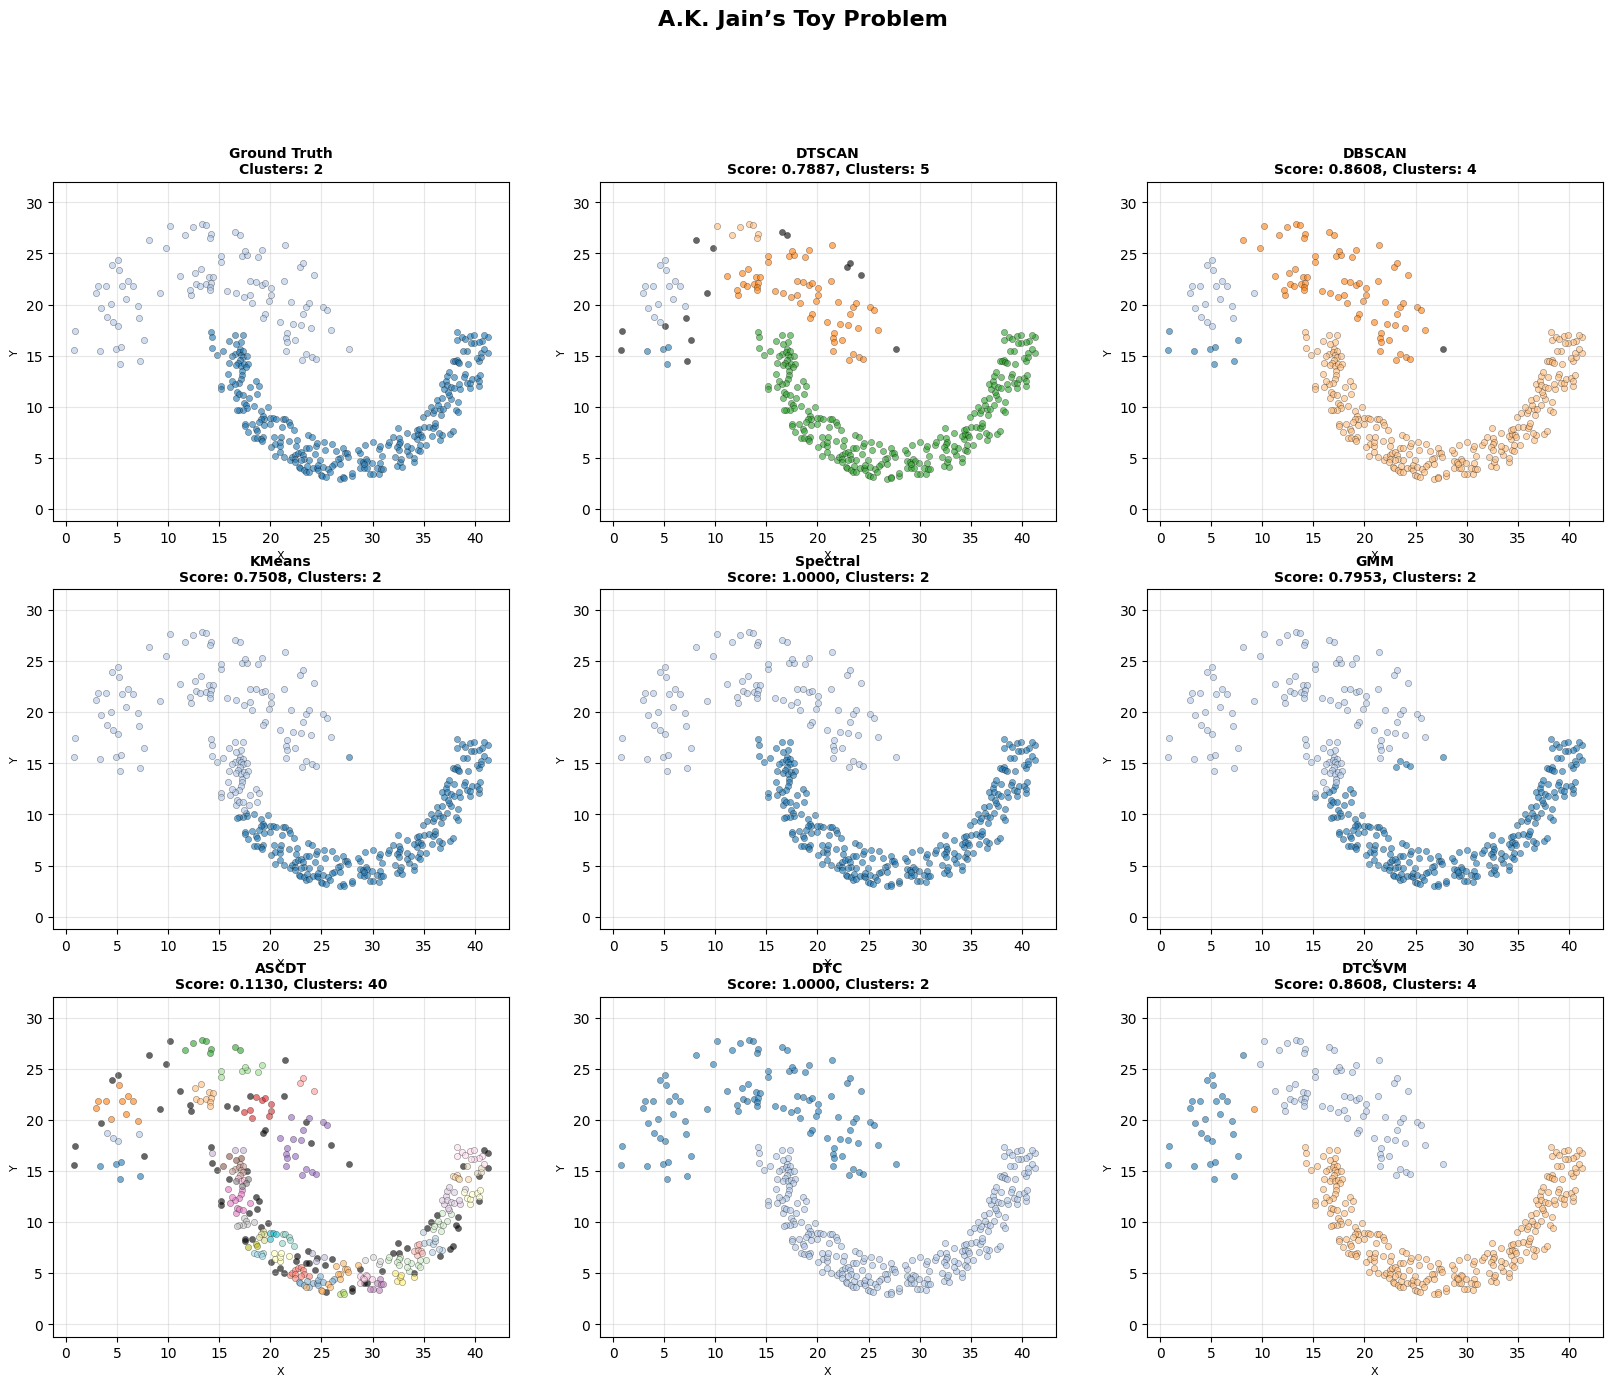

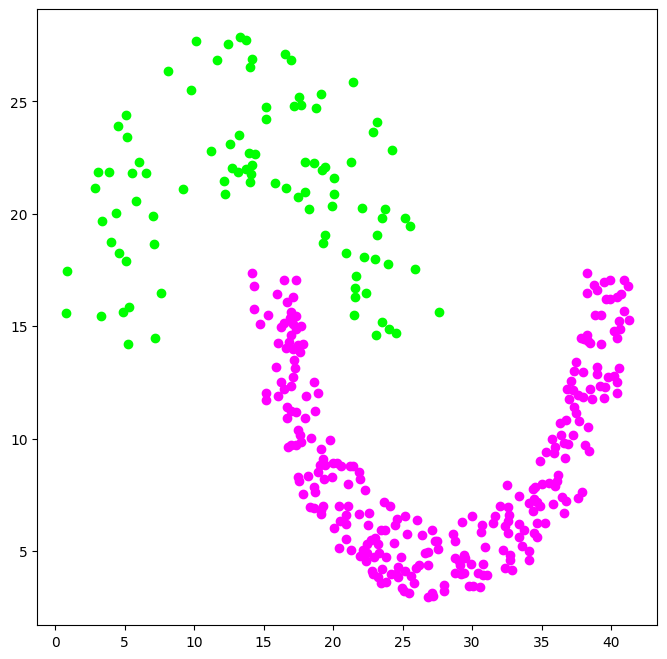

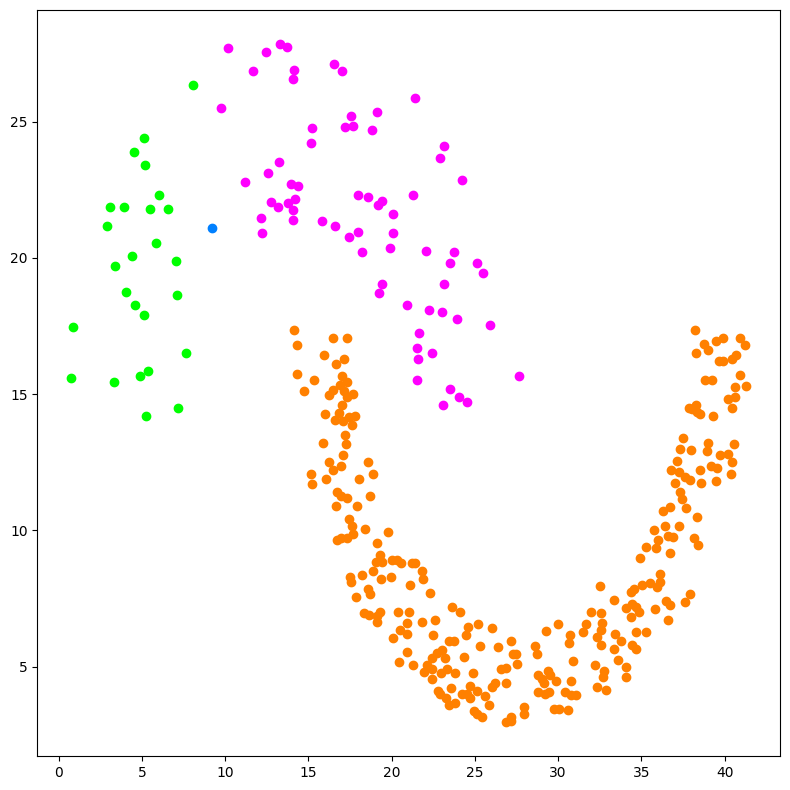

✓ S3 visualization complete


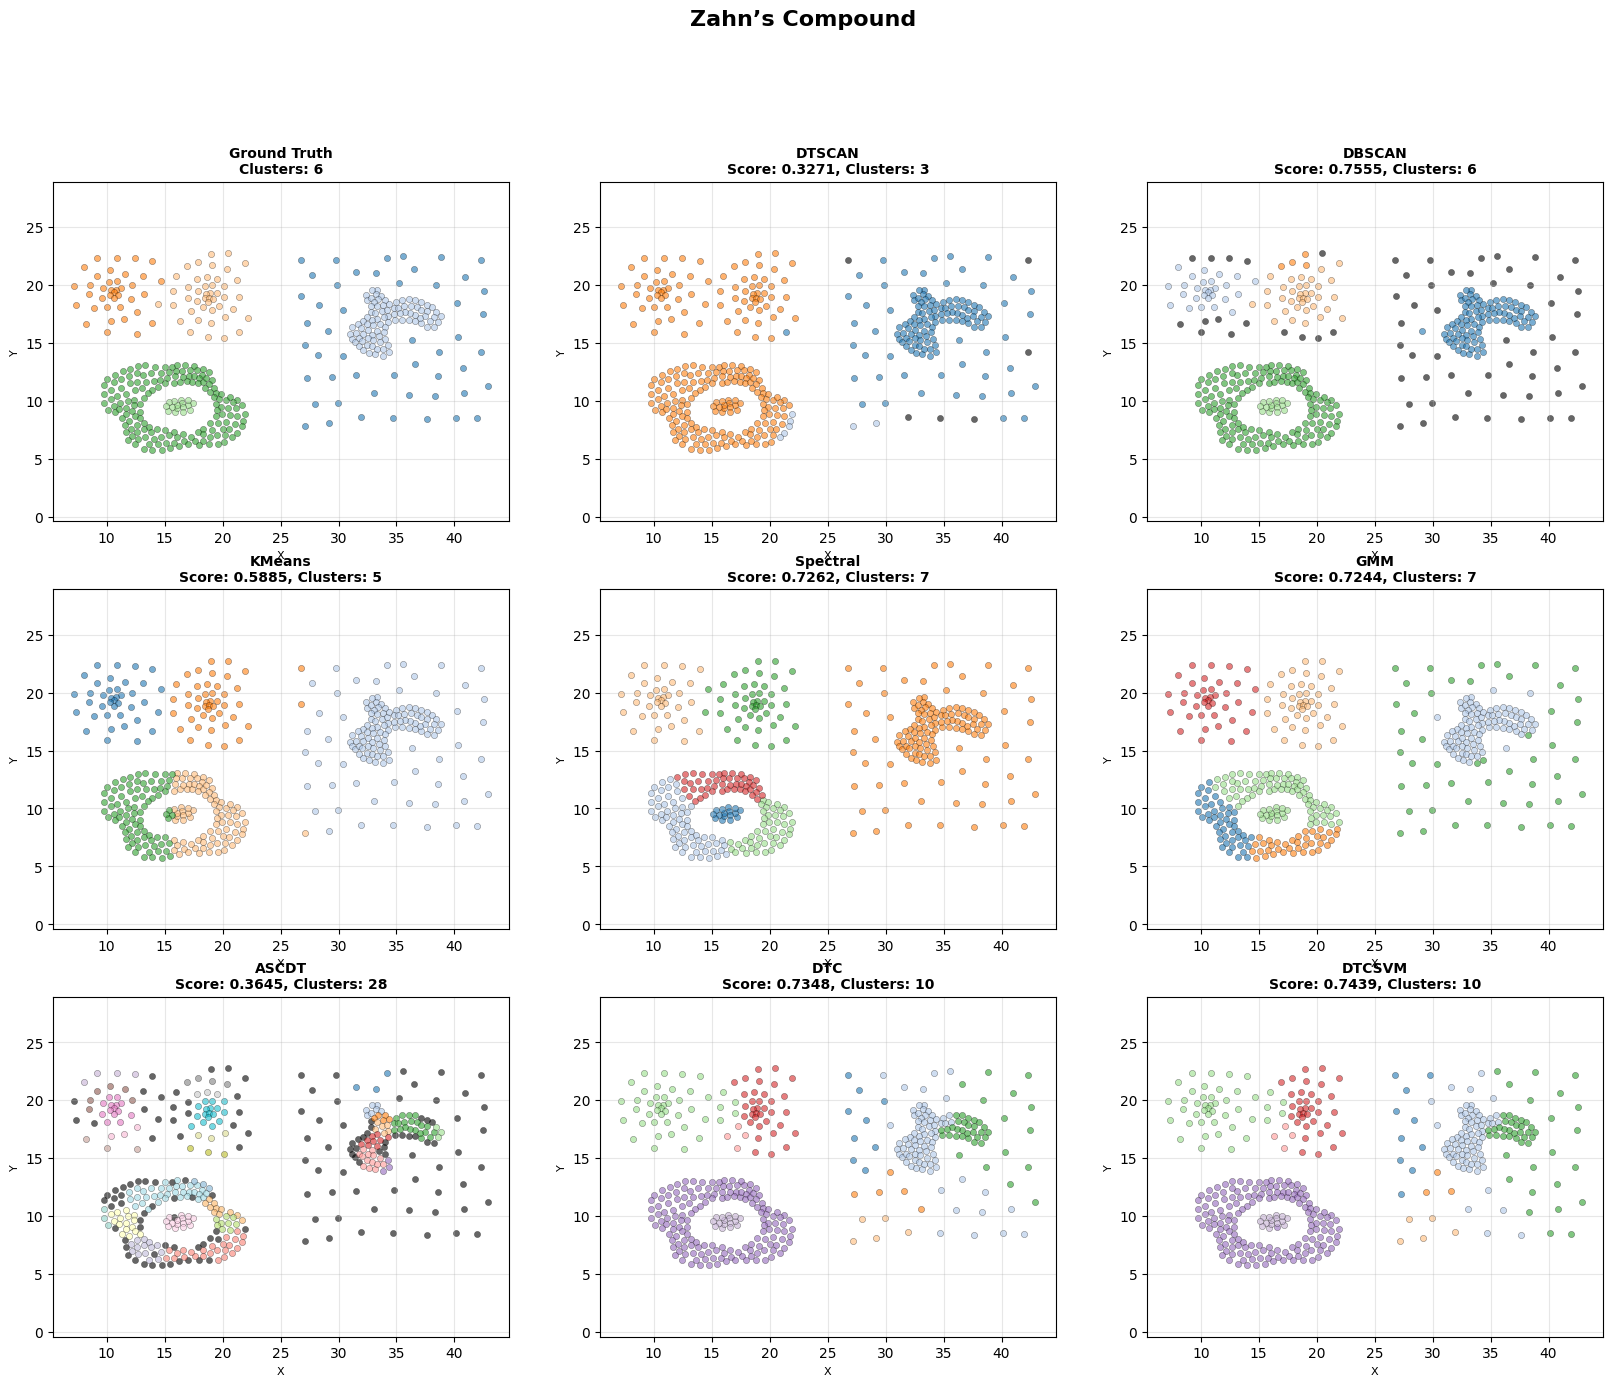

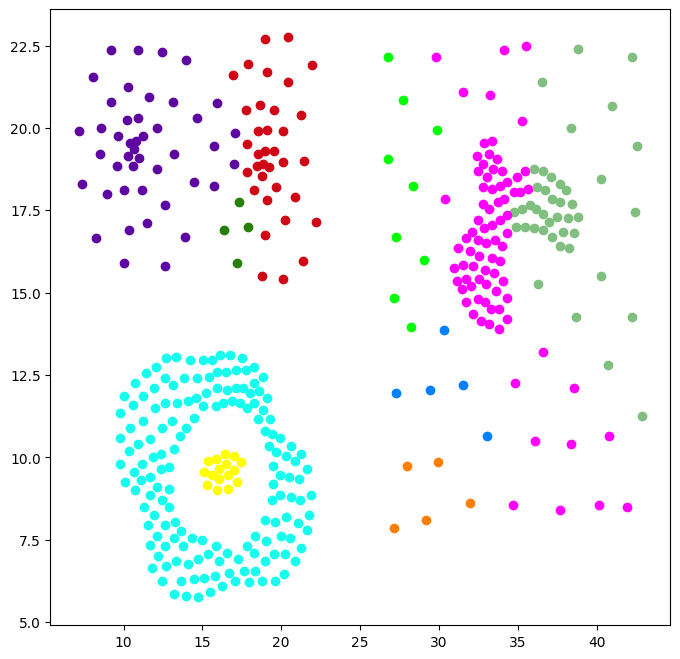

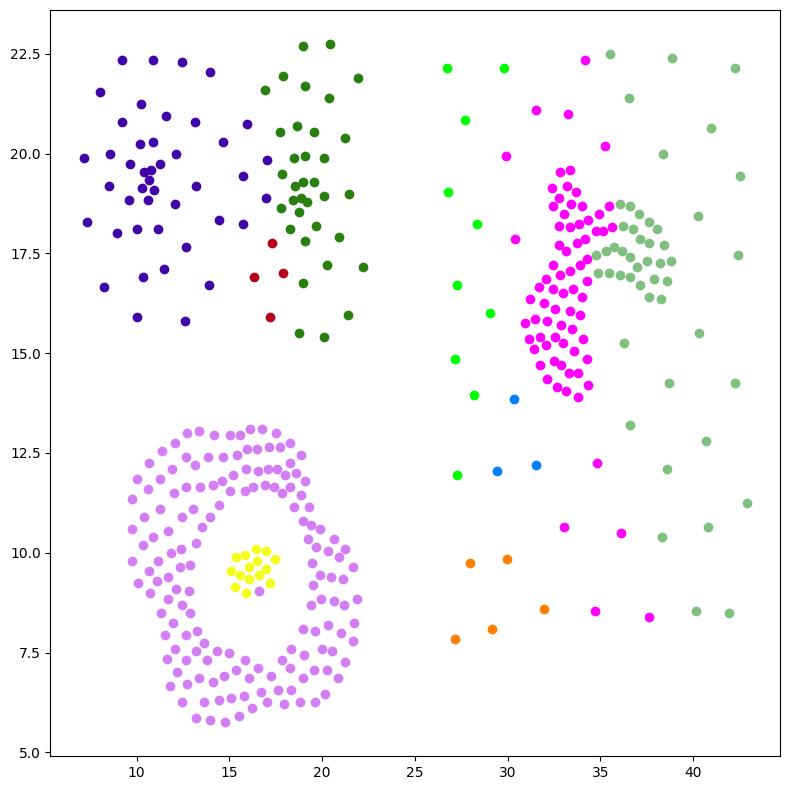

✓ S4 visualization complete


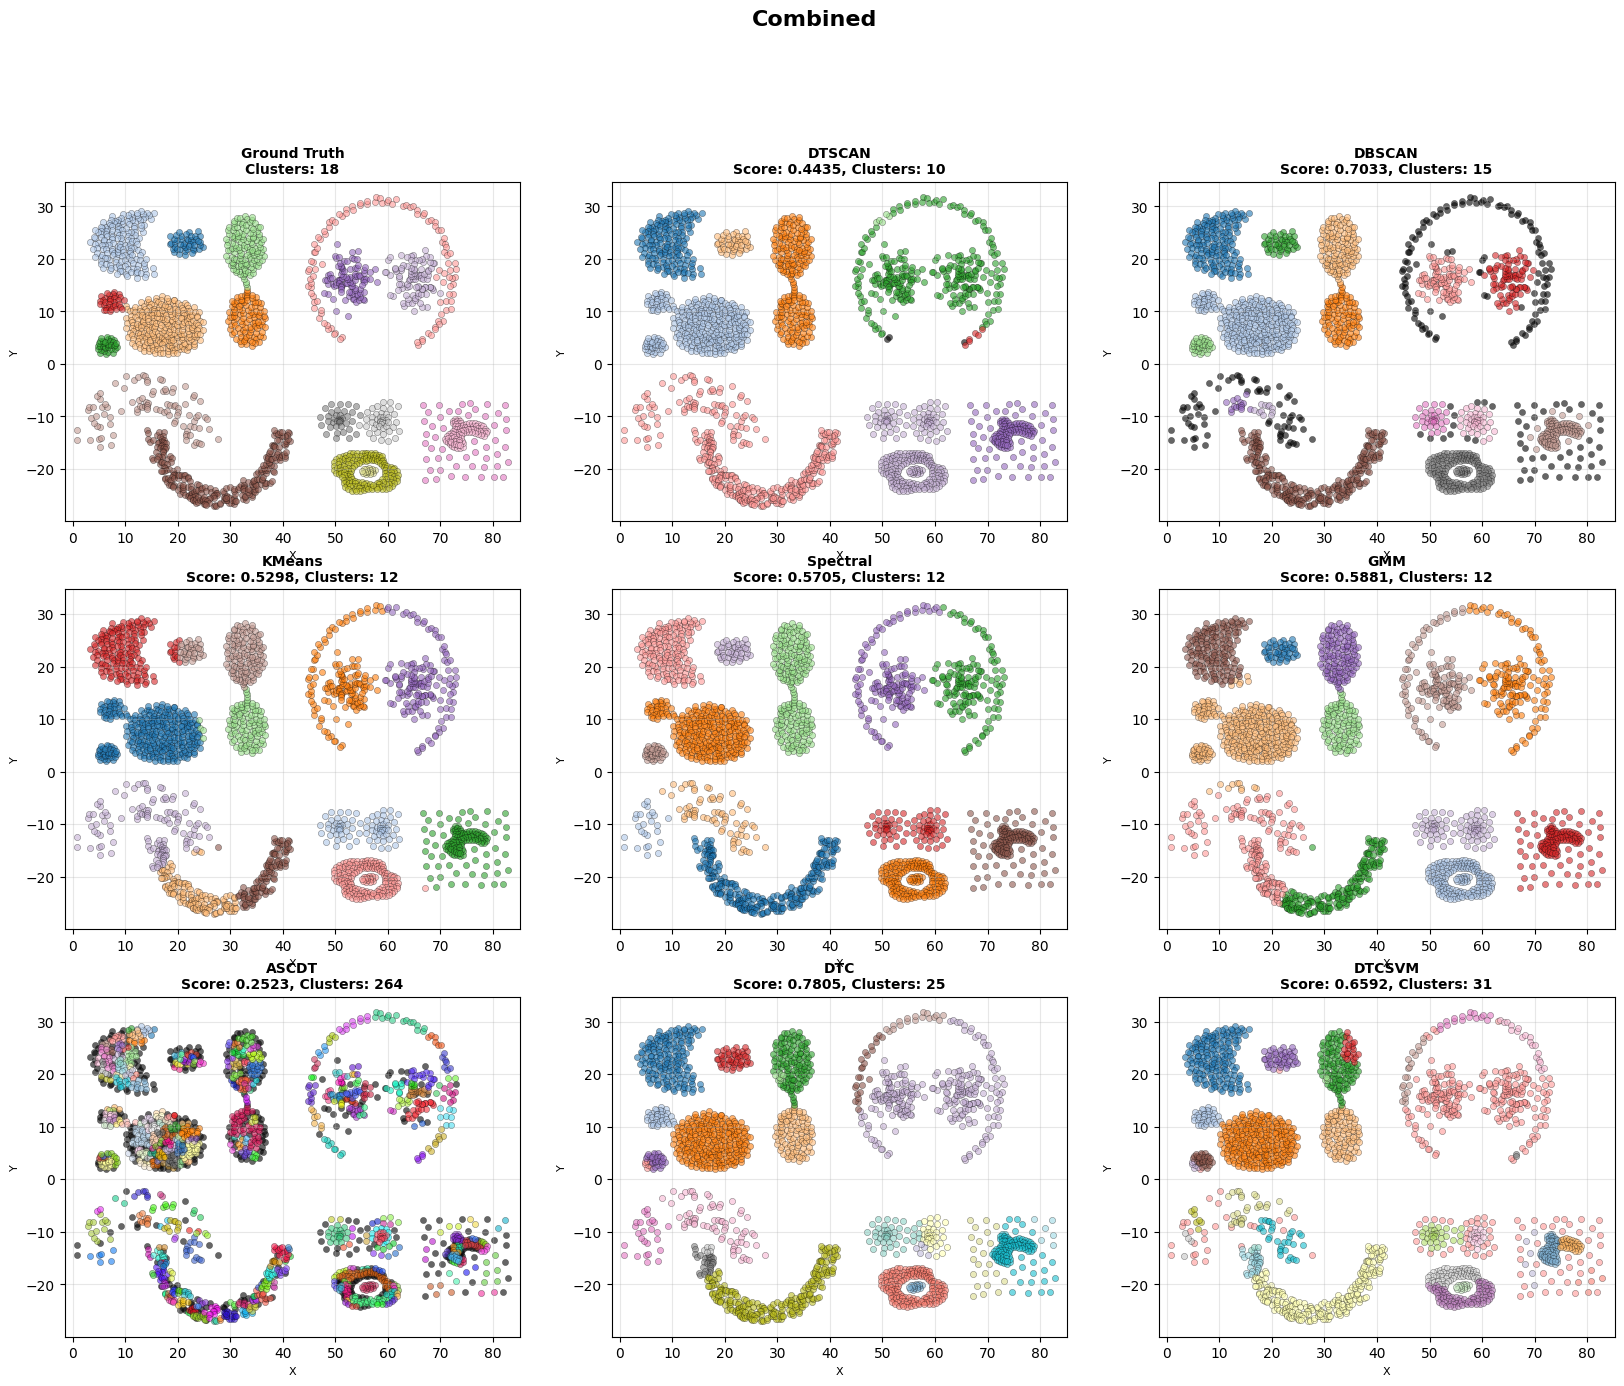

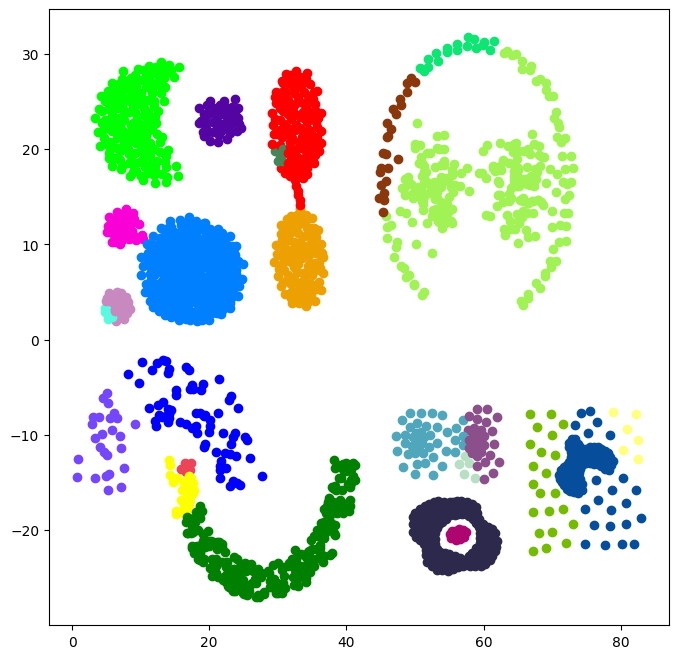

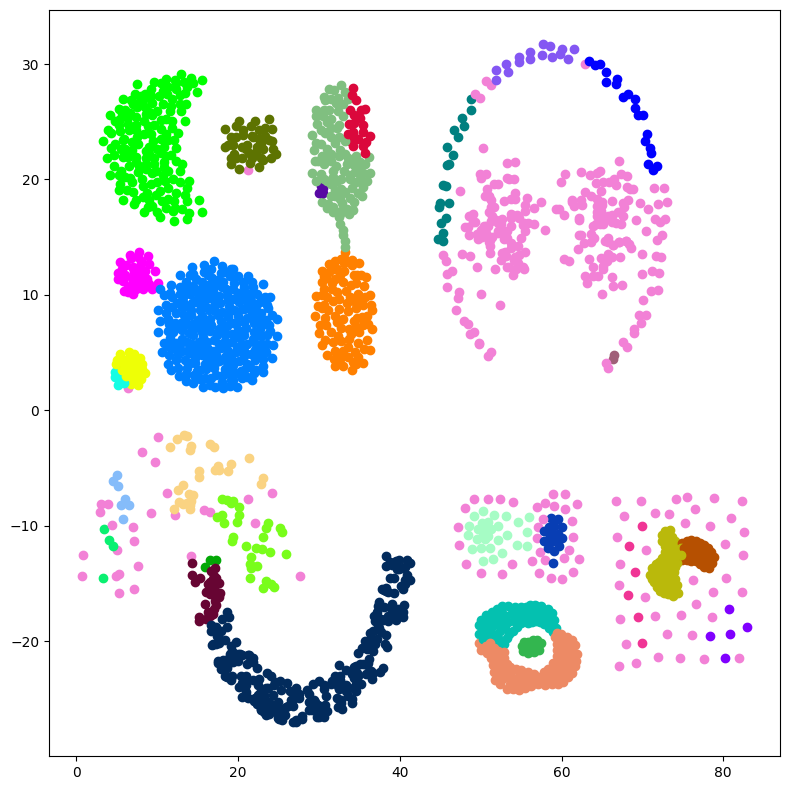

✓ S5 visualization complete

✓ All visualizations generated


In [27]:
# Create visualization grid for each dataset
print("Generating visualization grids...")
print("="*80)

names = [
    'Aggregation', 'Path-based', 'A.K. Jain’s Toy Problem',  'Zahn’s Compound', 'Combined'
]

for idx, dataset_name in enumerate(datasets.keys()):
    if dataset_name not in results:
        continue
    
    X, true_labels = datasets[dataset_name]
    X_scaled = StandardScaler().fit_transform(X)
    
    dataset_results = results[dataset_name]
    
    # Create figure with 3x3 grid (ground truth + 8 algorithms)
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle(f'{names[idx]}', fontsize=16, fontweight='bold', y=0.995)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten()
    
    # Plot ground truth in first cell
    n_true_clusters = len(np.unique(true_labels[true_labels != -1]))
    true_title = f'Ground Truth\nClusters: {n_true_clusters}'
    plot_clusters(X, true_labels, axes_flat[0], true_title)
    
    # Plot algorithms starting from second cell
    algo_idx = 1
    for algorithm in ALGORITHMS:
        if algorithm not in dataset_results:
            continue
        
        result = dataset_results[algorithm]
        best_params = result['best_params'].copy()
        
        # Run clustering with best parameters
        labels = cluster_data(X, X_scaled, algorithm, best_params)
        
        if labels is None:
            continue
        
        ax = axes_flat[algo_idx]
        score = result['best_score']
        n_clusters = result.get('n_clusters', len(np.unique(labels[labels != -1])))
        title = f'{algorithm}\nScore: {score:.4f}, Clusters: {n_clusters}'
        
        plot_clusters(X, labels, ax, title)
        algo_idx += 1
    
    # Hide unused subplots (should be none since we have ground truth + 8 algorithms = 9 cells)
    for idx in range(algo_idx, 9):
        axes_flat[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"✓ {dataset_name} visualization complete")

print("\n✓ All visualizations generated")


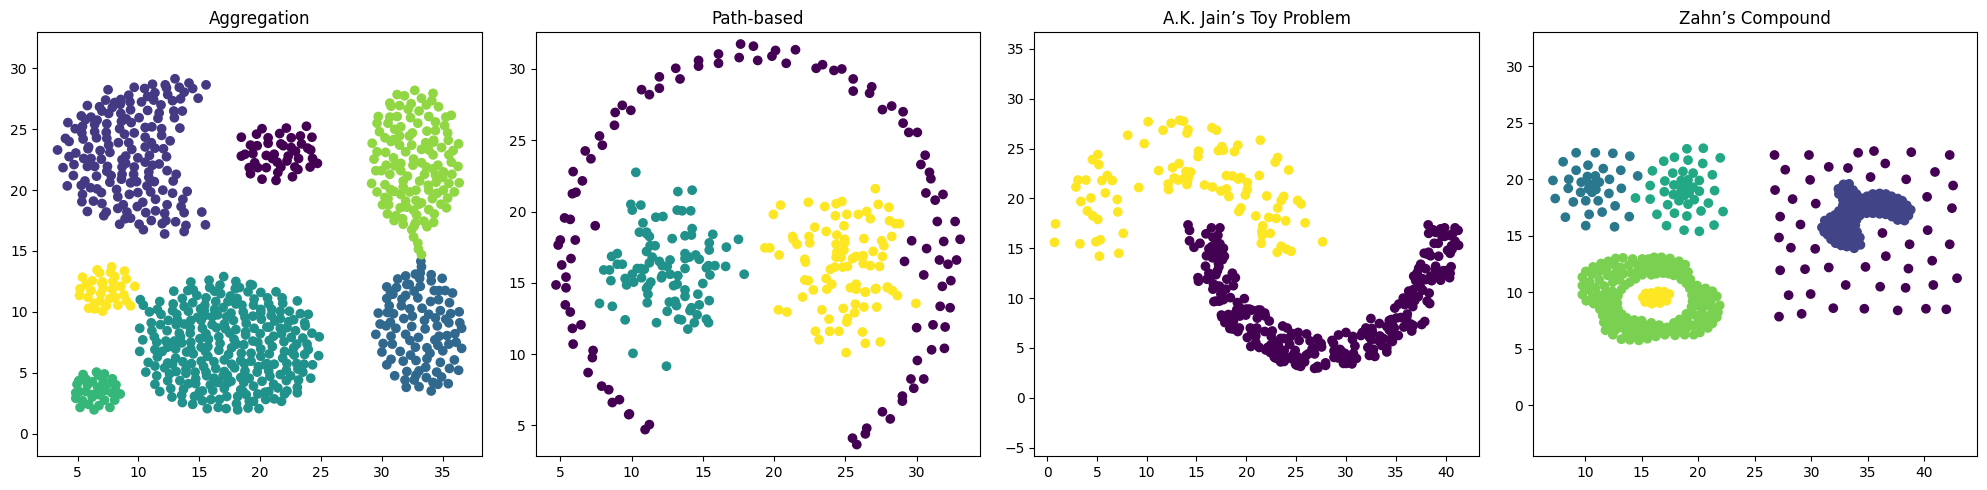

In [28]:
# plot all the ground truth into a 1x4 grid
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# take only S1, S2, S3, S4
datasets_to_plot = ['S1', 'S2', 'S3', 'S4']
for idx, dataset_name in enumerate(datasets_to_plot):
    if dataset_name not in results:
        continue
    
    X, true_labels = datasets[dataset_name]
    axes[idx].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis')
    axes[idx].set_title(names[idx])
    axes[idx].axis('equal')

plt.tight_layout()
plt.show()
    

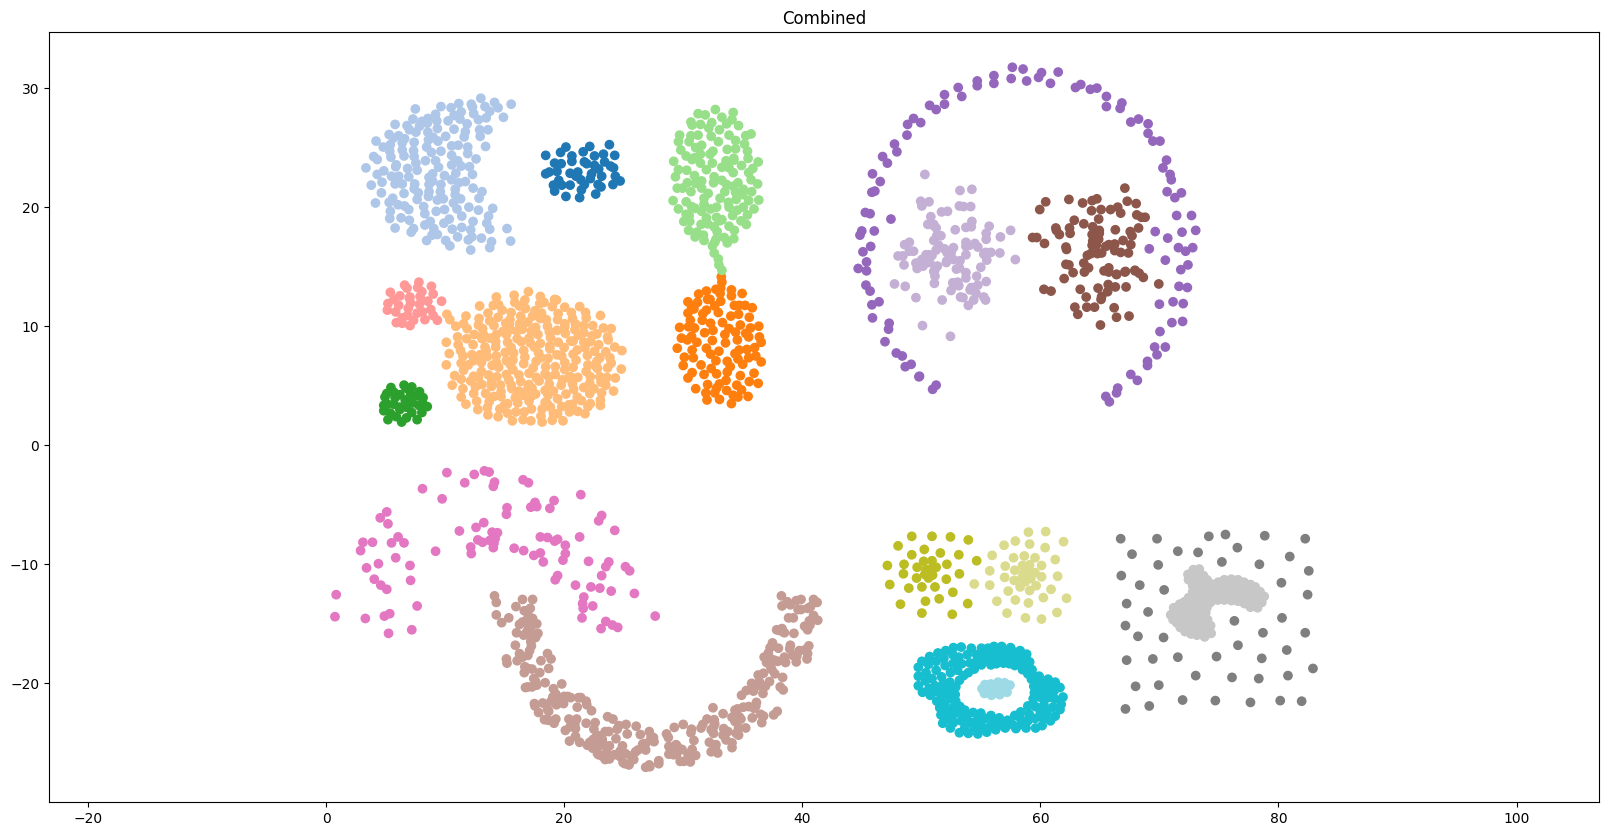

In [39]:
#plot just s5
X, true_labels = datasets['S5']
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='tab20')
ax.set_title(names[4])
ax.axis('equal')
plt.show()



In [100]:
# Convert results to DataFrame
results_df = results_to_dataframe(results)
results_df.Score = results_df.Score.round(3)
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))


RESULTS SUMMARY
Dataset Algorithm  Score  N Clusters  Expected Time (s)                                                                                                         Best Params
     S1       GMM  0.998           7         7    288.8                                   {'use_scaled': False, 'n_components': 7, 'covariance_type': 'full', 'n_init': 20}
     S1    DTCSVM  0.998           7         7    507.1                   {'min_pts': 4, 'local_std': 1.4082251601460674, 'svm_c': 2.742347145547971, 'svm_gamma': 'scale'}
     S1       DTC  0.991           7         7    492.9                                                                     {'min_pts': 5, 'local_std': 1.3855995759569955}
     S1    DTSCAN  0.990           7         7      3.8 {'use_scaled': False, 'MinPts': 5, 'area_threshold': -29.022030747106857, 'length_threshold': -0.20391842769989874}
     S1  Spectral  0.986           7         7    335.0                                                           {'use_sca

In [90]:
# display as dataframe the best 5 scores for each dataset
sub_dfs = []
i = 0
for dataset in datasets.keys():
    dataset_df = results_df[results_df['Dataset'] == dataset]
    dataset_df['Dataset'] = names[i]
    dataset_df['Score'] = dataset_df['Score'].round(2)
    sub_dfs.append(dataset_df.head(2)[['Dataset', 'Algorithm', 'Score']])
    i += 1
# make score be just 2 decimal places

top_5s = pd.concat(sub_dfs)

top_5s.to_csv('top_5sv2.csv', index=False)
top_5s

Dataset Algorithm  Score
4               Aggregation       GMM   1.00
7               Aggregation    DTCSVM   1.00
12               Path-based       GMM   0.75
11               Path-based  Spectral   0.73
19  A.K. Jain’s Toy Problem  Spectral   1.00
22  A.K. Jain’s Toy Problem       DTC   1.00
25          Zahn’s Compound    DBSCAN   0.76
31          Zahn’s Compound    DTCSVM   0.74
38                 Combined       DTC   0.78
33                 Combined    DBSCAN   0.70

In [102]:
# get the ones each got to their highest score for DTCSVM, DTC, ASCDT, DTSCAN
dtcsvm_df = results_df[results_df['Algorithm'] == 'DTCSVM'][['Score', 'Dataset']]
dtc_df = results_df[results_df['Algorithm'] == 'DTC'][['Score', 'Dataset']]
ascdt_df = results_df[results_df['Algorithm'] == 'ASCDT'][['Score', 'Dataset']]
dtscan_df = results_df[results_df['Algorithm'] == 'DTSCAN'][['Score', 'Dataset']]

# get the best for each of them into a single dataframe
best_df = pd.concat([dtcsvm_df.loc[dtcsvm_df['Score'].idxmax()], 
                     dtc_df.loc[dtc_df['Score'].idxmax()], 
                     ascdt_df.loc[ascdt_df['Score'].idxmax()], 
                     dtscan_df.loc[dtscan_df['Score'].idxmax()]], axis=1)

# make algorithm the name of the columns
best_df.columns = ['DTCSVM', 'DTC', 'ASCDT', 'DTSCAN']

# make score be just 2 decimal places

best_df.to_csv('best_v2.csv', index=False)
best_df



DTCSVM  DTC  ASCDT DTSCAN
Score    0.998  1.0  0.365   0.99
Dataset     S1   S3     S4     S1

## Best Algorithm per Dataset

In [17]:
print("\n" + "="*80)
print("BEST ALGORITHM PER DATASET")
print("="*80)

for dataset in datasets.keys():
    dataset_df = results_df[results_df['Dataset'] == dataset]
    if len(dataset_df) > 0:
        best = dataset_df.loc[dataset_df['Score'].idxmax()]
        print(f"\n{dataset}: {best['Algorithm']} (Score: {best['Score']:.4f})")
        print(f"  Params: {best['Best Params']}")


BEST ALGORITHM PER DATASET

S1: GMM (Score: 0.9975)
  Params: {'use_scaled': False, 'n_components': 7, 'covariance_type': 'full', 'n_init': 20}

S2: GMM (Score: 0.7502)
  Params: {'use_scaled': False, 'n_components': 7, 'covariance_type': 'diag', 'n_init': 10}

S3: Spectral (Score: 1.0000)
  Params: {'use_scaled': False, 'n_clusters': 2, 'n_neighbors': 30}

S4: DBSCAN (Score: 0.7555)
  Params: {'eps': 0.2042280409669427, 'min_samples': 4}

S5: DTC (Score: 0.7805)
  Params: {'min_pts': 3, 'local_std': 1.28017229668789}


## Export Results

## View Results in MLflow

To view the results in MLflow UI, run:

```bash
mlflow ui --backend-store-uri file:../mlruns
```

Then open http://localhost:5000 in your browser.

## Detailed Results per Dataset

In [18]:
# Display detailed results for each dataset
for dataset_name in datasets.keys():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"{'='*80}\n")
    
    if dataset_name in results:
        dataset_results = results[dataset_name]
        
        for algo_name in ALGORITHMS:
            if algo_name in dataset_results:
                result = dataset_results[algo_name]
                print(f"\n{algo_name}:")
                print(f"  Score: {result['best_score']:.4f}")
                print(f"  N Clusters: {result.get('n_clusters', 'N/A')} (Expected: {result['expected_clusters']})")
                print(f"  Time: {result['duration']:.1f}s")
                print(f"  Best Params: {result['best_params']}")


DATASET: S1


DTSCAN:
  Score: 0.9896
  N Clusters: 7 (Expected: 7)
  Time: 3.8s
  Best Params: {'use_scaled': False, 'MinPts': 5, 'area_threshold': -29.022030747106857, 'length_threshold': -0.20391842769989874}

DBSCAN:
  Score: 0.9694
  N Clusters: 7 (Expected: 7)
  Time: 0.9s
  Best Params: {'eps': 0.12760164222834047, 'min_samples': 6}

KMeans:
  Score: 0.8080
  N Clusters: 9 (Expected: 7)
  Time: 352.7s
  Best Params: {'use_scaled': False, 'n_clusters': 9, 'n_init': 20}

Spectral:
  Score: 0.9861
  N Clusters: 7 (Expected: 7)
  Time: 335.0s
  Best Params: {'use_scaled': False, 'n_clusters': 7, 'n_neighbors': 12}

GMM:
  Score: 0.9975
  N Clusters: 7 (Expected: 7)
  Time: 288.8s
  Best Params: {'use_scaled': False, 'n_components': 7, 'covariance_type': 'full', 'n_init': 20}

ASCDT:
  Score: 0.1977
  N Clusters: 36 (Expected: 7)
  Time: 25.3s
  Best Params: {'use_scaled': True, 'min_cluster_size': 6, 'beta': 1.2725393652234676}

DTC:
  Score: 0.9910
  N Clusters: 7 (Expected: 7)
  